In [1]:
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)
import math
import collections

Tensorflow version:  2.4.0


In [2]:
from saved_class_Animator import Animator
from saved_class_Timer import Timer
from saved_class_Accumulator import Accumulator
from saved_class_MaskedSoftmaxCELoss import MaskedSoftmaxCELoss
from saved_func_grad_clipping import grad_clipping
from saved_func_try_gpu import try_gpu
from saved_func_load_data_nmt import *
from saved_func_load_data_nmt import truncate_pad

## Encoder

In [3]:
class Seq2SeqEncoder(tf.keras.layers.Layer):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout = 0, **kwargs): 
        super().__init__(*kwargs)
        # Embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)
    
    def call(self, X, training, *args):
        # The input `X` shape: (`batch_size`, `num_steps`)
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        output = self.rnn(X, training = training)
        state = output[1:]
        return output[0], state

In [4]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
X = tf.zeros((4, 7))
output, state = encoder(X)
output.shape

TensorShape([4, 7, 16])

In [5]:
len(state)    # Length of `state` is same as `num_layers` in Stacked RNN.

2

In [6]:
[element.shape for element in state]

[TensorShape([4, 16]), TensorShape([4, 16])]

## Decoder

In [7]:
class Seq2SeqDecoder(tf.keras.layers.Layer):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout = 0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)
        self.dense = tf.keras.layers.Dense(vocab_size)
        
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    
    def call(self, X, state, training):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # Broadcast `context` so it has the same `num_steps` as `X`. Context has shape: (`batch_size`, `embed_size`)
        context = tf.repeat(tf.expand_dims(state[-1], axis = 1), repeats = X.shape[1], axis = 1)
        X_and_context = tf.concat((X, context), axis = 2)
        rnn_output = self.rnn(X_and_context, state, training = training)
        output = self.dense(rnn_output[0])
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` is a list with `num_layers` entries. Each entry has shape: (`batch_size`, `num_hiddens`)
        return output, rnn_output[1:]

In [8]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
state = decoder.init_state(encoder(X))
output, state = decoder(X, state, training = False)
print(output.shape)

(4, 7, 10)


In [9]:
len(state)    # Length of `state` is same as `num_layers` in Stacked RNN.

2

In [10]:
[val.shape for val in state]

[TensorShape([4, 16]), TensorShape([4, 16])]

## Loss function

In [11]:
def sequence_mask(X, valid_len, value = 0):
    """Mask irrelevant entries in sequences.
    Input argument X of this function is 2D.
    """
    maxlen = X.shape[1]
    mask = tf.range(start = 0, limit = maxlen, dtype = tf.float32)[None, :] < tf.cast(valid_len[:, None], dtype = tf.float32)
    return tf.where(mask, X, value)

In [12]:
X = tf.constant([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, tf.constant([1, 2]))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [4, 5, 0]])>

## Note:
The previous function expects input `X` to be a 2D tensor. If `X` is a 3D tensor, we can modify the function slightly to make it work. We could have incorporated both the cases in a single function but we have avoided doing that. We use `sequence_mask` exclusively for 2D input X. 

In [13]:
def sequence_mask_only_for_3D_input(X, valid_len, value  = 0):
    """This function is only for 3D input X."""
    maxlen = X.shape[1]
    mask = tf.range(start = 0, limit = maxlen, dtype = tf.float32)[None, :] < tf.cast(valid_len[:, None], dtype = tf.float32)
    return tf.where(tf.expand_dims(mask, axis = -1), X, value)

In [14]:
X = tf.ones((2, 3, 4))
sequence_mask_only_for_3D_input(X, tf.constant([1, 2]), value=-1)

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[ 1.,  1.,  1.,  1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [-1., -1., -1., -1.]]], dtype=float32)>

In [15]:
class MaskedSoftmaxCELoss(tf.keras.losses.Loss):
    """The softmax cross-entropy loss with masks."""
    def __init__(self, valid_len):
        super().__init__(reduction = 'none')
        self.valid_len = valid_len
    
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def call(self, label, pred):
        weights = tf.ones_like(label, dtype = tf.float32)
        weights = sequence_mask(weights, self.valid_len)
        label_one_hot = tf.one_hot(label, depth = pred.shape[-1])
        unweighted_loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True, reduction = 'none')(label_one_hot,
                                                                                                          pred)
        weighted_loss = tf.reduce_mean((unweighted_loss * weights), axis = 1)
        return weighted_loss

In [16]:
loss = MaskedSoftmaxCELoss(tf.constant([4, 2, 0]))
loss(tf.ones((3,4), dtype = tf.int32), tf.ones((3, 4, 10))).numpy()

array([2.3025851, 1.1512926, 0.       ], dtype=float32)

## Training

In [17]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    animator = Animator(xlabel = "epoch", ylabel = "loss", xlim = [10, num_epochs])
    
    for epoch in range(num_epochs):
        timer = Timer()
        metric = Accumulator(2)   # Sum of training loss, no. of tokens
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x for x in batch]
            bos = tf.reshape(tf.constant([tgt_vocab['<bos>']] * Y.shape[0]), shape = (-1, 1))
            dec_input = tf.concat([bos, Y[:, :-1]], 1)   # Teacher forcing
            with tf.GradientTape() as tape:
                Y_hat, _ = net(X, dec_input, X_valid_len, training = True)
                l = MaskedSoftmaxCELoss(Y_valid_len)(Y, Y_hat)
            gradients = tape.gradient(l, net.trainable_variables)
            gradients = grad_clipping(gradients, 1)
            optimizer.apply_gradients(zip(gradients, net.trainable_variables))
            num_tokens = tf.reduce_sum(Y_valid_len).numpy()
            metric.add(tf.reduce_sum(l), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} ' f'tokens/sec on {str(device)}')

In [18]:
class EncoderDecoder(tf.keras.Model):
    def __init__(self, src_vocab_len, embed_size, num_hiddens, num_layers, tgt_vocab_len, dropout, **kwargs):
        super().__init__(**kwargs)
        self.encoder = Seq2SeqEncoder(src_vocab_len, embed_size, num_hiddens, num_layers, dropout)
        self.decoder = Seq2SeqDecoder(tgt_vocab_len, embed_size, num_hiddens, num_layers, dropout)
        
    def call(self, enc_X, dec_X, valid_len, training):
        enc_outputs = self.encoder(enc_X, training = training)
        dec_state = self.decoder.init_state(enc_outputs, valid_len)
        return self.decoder(dec_X, dec_state, training = training)

loss 0.025, 982.7 tokens/sec on /GPU:0


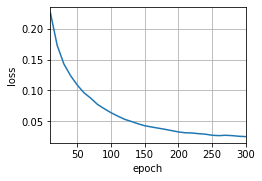

In [19]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
net = EncoderDecoder(len(src_vocab), embed_size, num_hiddens, num_layers, len(tgt_vocab), dropout)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## Prediction

In [20]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, save_attention_weights = False):
    """Predict for sequence to sequence."""
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = tf.constant([len(src_tokens)])
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = tf.expand_dims(src_tokens, axis = 0)
    enc_outputs = net.encoder(enc_X, training = False)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = tf.expand_dims(tf.constant([tgt_vocab['<bos>']]), axis = 0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state, training = False)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = tf.argmax(Y, axis = 2)
        pred = tf.squeeze(dec_X, axis = 0)
        # Save attention weights
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights())
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred.numpy())
    return ' '.join(tgt_vocab.to_tokens(tf.reshape(output_seq, shape = -1).numpy().tolist())), attention_weight_seq

## Evaluation of predicted sequences

In [21]:
def bleu(label_seq, pred_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [22]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est riche ., bleu 0.658
i'm home . => je suis malade ., bleu 0.548
